# 1.1 Evaluate the Accuracy of Service Metric Estimation

1) Use linear regression to train a model M with the training set. Provide coefficients  (𝑤1,𝑤2,...)  and bias b of your model M.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

X = pd.read_csv('data/X.csv')
Y = pd.read_csv('data/Y.csv')
Y['TimeStamp'] = Y.TimeStamp.astype(int)

joined_dataframe = X.merge(Y, on=['TimeStamp'], how='inner')
joined_dataframe.index = pd.to_datetime(
    joined_dataframe['TimeStamp'], unit='s')

x = joined_dataframe.drop(['TimeStamp', 'DispFrames'], axis=1)
y = joined_dataframe[['DispFrames']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
y_predict = regression_model.predict(X_test)


for idx, col_name in enumerate(X_train.columns):
    print("w{} -> The coefficient for {}: {}".format(idx + 1, col_name,
                                                   np.round(regression_model.coef_[0][idx], decimals=3)))

intercept = np.round(regression_model.intercept_[0], decimals=3)
print("The bias b: {}".format(intercept))


w1 -> The coefficient for runq-sz: -0.019
w2 -> The coefficient for %%memused: 0.208
w3 -> The coefficient for proc/s: -0.0
w4 -> The coefficient for cswch/s: -0.0
w5 -> The coefficient for all_%%usr: 0.079
w6 -> The coefficient for ldavg-1: 0.01
w7 -> The coefficient for totsck: -0.005
w8 -> The coefficient for pgfree/s: -0.0
w9 -> The coefficient for plist-sz: -0.007
w10 -> The coefficient for file-nr: 0.003
w11 -> The coefficient for idel/s: -0.0
w12 -> The coefficient for tps: 0.006
The bias b: 17.575


2) the Normalized Mean Absolute Error (NMAE)

In [5]:
def get_nmae(y_predict, y_test):
    m = y_test['DispFrames'].count()
    y_mean = y_test['DispFrames'].mean()
    y_predict = regression_model.predict(X_test)

    sum_abs_y_mean_predict = 0.0
    i = 0
    for _, row in y_test.iterrows():
        sum_abs_y_mean_predict += abs(row['DispFrames'] - y_predict[i][0])
        i += 1

    nmae = (sum_abs_y_mean_predict / m) / y_mean
    return np.round(nmae, decimals=8)

print("nmae of the model: {}".format(get_nmae(y_predict, y_test)))
y_test_mean = y_test['DispFrames'].mean()  # for naive prediction
print("mean of y_test['DispFrames']: {}".format(y_test_mean))

nmae of the model: 0.09564229
mean of y_test['DispFrames']: 19.44880554477405


3) Produce a time series plot that shows both the measurements and the model estimation for M for the Video Frame Rate values in the test set

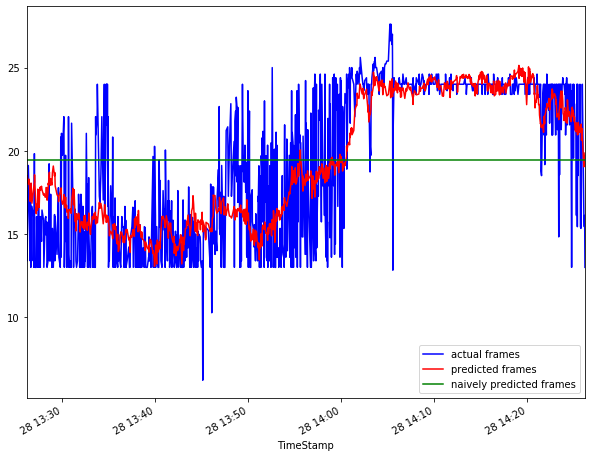

In [12]:
import matplotlib.pyplot as plt

joined_result = y_test.copy()
joined_result['predict'] = y_predict
joined_result['naively_predict'] = np.full((y_test['DispFrames'].count(), 1),
                                           y_test_mean)

plt.figure(figsize=(10, 8))
joined_result['DispFrames'].plot(color='blue')
joined_result['predict'].plot(color='red')
joined_result['naively_predict'].plot(color='green')
plt.legend(('actual frames', 'predicted frames', 'naively predicted frames'),
           loc='lower right', shadow=False, fancybox=True)
plt.show()


4) Produce a density plot and a histogram for the Video Frame Rate values in the test set

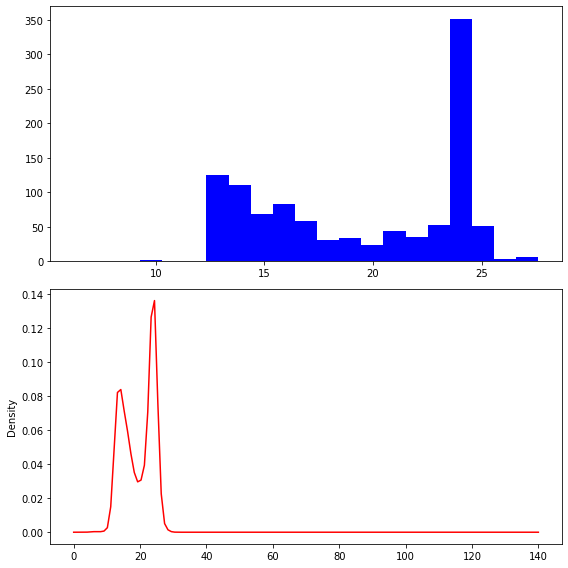

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
n_bins = int(y_test['DispFrames'].max() - y_test['DispFrames'].min())
axes[0].hist(y_test['DispFrames'], bins=n_bins, color='b')
y_test['DispFrames'].plot.kde(ind=np.linspace(0, 140, 139), color='r')
plt.tight_layout()
plt.show()

5) Produce a density plot for the prediction error  𝑦𝑖−𝑦̂ 𝑖  in the test set.

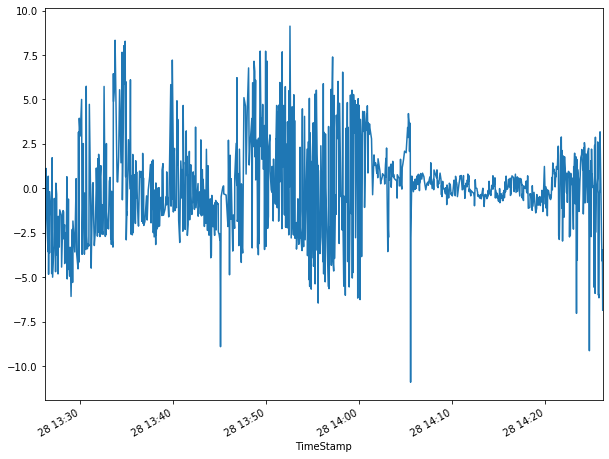

In [16]:
joined_result['estimation_errors'] = np.array(
    [(row['DispFrames'] - row['predict'])
        for _, row in joined_result.iterrows()])

plt.figure(figsize=(10, 8))
joined_result['estimation_errors'].plot()
plt.show()

# 1.2 Relation between Estimation Accuracy and size of training set

a) From the training set with 2520 observation, create six training sets by selecting uniformly at random 50,100,200, 500,1000 and 2520 observations (which is the original set).
b) Train a linear model and compute the NMAE for each model for the original test set with 1080 observations.
c) Perform the above 50 times, so you train models for 50 different subsets of a given size.
d) Produce a plot that shows NMAE for M against the size of the training set. Use error bars or box plots to show the range of the NMAE values for a given set size.

In [ ]:
training_test_sizes = [50, 100, 200, 500, 1000, 2520]

# Still uses the y_test from the above code, which has 1080 observations. Don't change this.
nmaes_dict = {}
for train_size in training_test_sizes:
    nmaes = []
    for i in range(0, 50):
        X_train_new, _, y_train_new, _ = train_test_split(x, y,
                                                            train_size=train_size)
        regression_model = LinearRegression()
        regression_model.fit(X_train_new, y_train_new)

        y_predict_new = regression_model.predict(X_train) # use the same old X_train[1080] data
        
        # function get_nmae is defined in the first section 1.1, part 2)
        nmaes.append(get_nmae(y_predict_new, y_test))
    
    nmaes_dict[train_size] = nmaes

nmaes_df = pd.DataFrame(data=nmaes_dict)
nmaes_df.boxplot(column = training_test_sizes)
plt.show()